# **Authors: Davy SIMEU, Romin DURAND, Joyce TCHAMDJOU**

# Import des librairies

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Utilitaires / Routines

In [2]:
# Récupération, formattage et affichage des données

def char_to_index(char):
    ascii = ord(char)
    if 48 <= ascii <= 57: # 0, 1, ..., 9
        return ascii-48
    elif 65 <= ascii <= 90: # A, B, ..., Z
        return ascii-65+10
    elif 97 <= ascii <= 122: # a, b, ..., z
        return ascii-97 + 10
    else:
        print('Error: {} is not a digit or a letter'.format(char))
        return -1

def index_to_char(index):
    if 0 <= index <= 9: # Digits
        return str(index)
    elif 10 <= index <= 35: # Letters
        return str(chr(index-10+65))

def plot_random_sample_of_each_char(X, n_sample_per_char=39, height=20, width=16, ncol=3):
    n, _ = X.shape
    if n%n_sample_per_char != 0:
        print('Warning: first dimension of X should be '
              + 'a multiple of n_sample_per_char={}'.format(n_sample_per_char))

    n_char = n//n_sample_per_char
    nrow = n_char//ncol + int(n_char%ncol>0)
    fig, axs = plt.subplots(nrow, ncol)
    for i in range(nrow*ncol):
        if nrow==1:
            ax = axs[i%ncol]
        else:
            ax = axs[i//ncol,i%ncol]

        if i < n_char:
            rand_ind = np.random.randint(i*n_sample_per_char, (i+1)*n_sample_per_char)
            rand_char = X[rand_ind]
            img = rand_char.reshape(height, width)
            ax.imshow(img)
            ax.axis('off')
        else:
            fig.delaxes(ax)

    plt.tight_layout()

def lire_alpha_digit(characters, n_sample_per_char=39, height=20, width=16):
    f = scipy.io.loadmat('binaryalphadigs.mat')
    data = f['dat']

    char_indices = [char_to_index(char) for char in characters if char_to_index(char)!=-1]
    char_indices = np.unique(char_indices)

    N_char = len(char_indices)
    n = n_sample_per_char*N_char
    p = height*width 

    X = np.zeros((n, p))
    for i, idx in enumerate(char_indices):
        for j in range(n_sample_per_char):
            k = i*n_sample_per_char + j
            line = data[idx, j].flatten()
            X[k] = line
    
    plot_random_sample_of_each_char(X)
    
    return X

# Affichage d'un historique d'une fonction d'erreur

def plot_err(err_history, ylabel='Reconstruction error (RMSE)'):
    plt.figure(figsize=(13, 7))
    plt.plot(err_history)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.show()

# Création de la classe RBM

In [3]:
class RBM():
    def __init__(self, p, q, var=1e-2):
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.W = np.random.normal(0, 1, size=(p, q))*np.sqrt(var)
        self.q = q
        self.p = p

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def entree_sortie(self, X):
        return self.sigmoid(X @ self.W + self.b)

    def sortie_entree(self, H):
        return self.sigmoid(H @ self.W.T + self.a)

    def train(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
        if verbose:
            print('Beginning training of the RBM...')
        n, p = X.shape
        err_history = []
        
        for epoch in range(nb_epoch):
            np.random.shuffle(X)
            
            for batch in range(0, n, batch_size):
                X_batch = X[batch:batch+batch_size]
                current_bs = X_batch.shape[0]

                # Calcul de v_0, v_1, p(v|h) et p(h|v)
                v_0 = X_batch 
                ph_v_0 = self.entree_sortie(v_0) 
                h_0 = (np.random.random((current_bs, self.q)) < ph_v_0).astype(int) 
                pv_h_0 = self.sortie_entree(h_0) 
                v_1 = (np.random.random((current_bs, p)) < pv_h_0).astype(int) 
                ph_v_1 = self.entree_sortie(v_1) 

                # Calcul du gradient (des dérivées partielles)
                grad_a = np.sum(v_0 - v_1, axis=0) 
                grad_b = np.sum(ph_v_0 - ph_v_1, axis=0) 
                grad_W = v_0.T @ ph_v_0 - v_1.T @ ph_v_1

                # Mise à jour des paramètres
                self.W += lr/current_bs * grad_W
                self.a += lr/current_bs * grad_a
                self.b += lr/current_bs * grad_b

            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)

            err = np.mean((X-X_rec)**2)**.5
            err_history.append(err)                
                
            if epoch % epoch_per_plot == 0 and verbose:
                print('Epoch {}/{} - RMSE: {:.4f}'.format(epoch+1, nb_epoch, err))
                rand_idx = np.random.randint(n)
                original_img = X[rand_idx].reshape(height, width)
                reconstructed_img = X_rec[rand_idx].reshape(height, width)
                
                _, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 2))
                ax1.imshow(original_img)
                ax1.axis('off')
                ax1.set_title('Original')
                
                ax2.imshow(reconstructed_img)
                ax2.axis('off')
                ax2.set_title('Reconstructed')
                plt.tight_layout()
                plt.show()

        return err_history

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p, q = self.W.shape
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)

            image = v.reshape(height, width)
            if nrow == 1:
                axs[i].imshow(image)
                axs[i].axis('off')
            elif ncol == 1:
                axs[i].imshow(image)
                axs[i].axis('off')
            else:
                axs[i//ncol, i%ncol].imshow(image)
                axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()
        
        
    def show_filter(self, height=20, ncol=5, nrow=2):
        idxs = np.random.randint(self.q, size=ncol*nrow)
        plt.figure(figsize=(10, 5))
        for i, idx in enumerate(idxs):
            weights = self.W[:, idx]
            filter = weights.reshape(height, self.p//height)
            
            plt.subplot(nrow, ncol, i+1)
            plt.axis('off')
            plt.imshow(filter, cmap='gray')
        plt.tight_layout()

# Exploitation du modèle RBM et analyse
## Exploitation
On affiche les images comportant le chiffre $1$. Elles sont extraites de la base de données ``Binary AlphaDigits`` et on constate qu'elles ne sont étrangement pas très révélatrices pour certaines.

Dimension des données d'entrées : 320


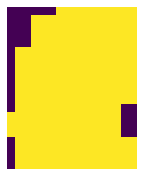

In [5]:
X_rbm = lire_alpha_digit("1")
_, p = X_rbm.shape
print("Dimension des données d'entrées :", p)

On crée un RBM ``rbm0`` avec $512$ unités cachées (qui représente l'espace latent) et on l'entraine sur l'ensemble des images extraites de la base de données ``Binary AlphaDigits`` qui représentent les chiffres $2, 3, 4, 5, 6, 7, 8, 9$ mis à part le chiffre $1$ qui est visiblement problématique. L'objectif étant à terme de pouvoir générer des images similaires.

Dimension des données d'entrées : 320


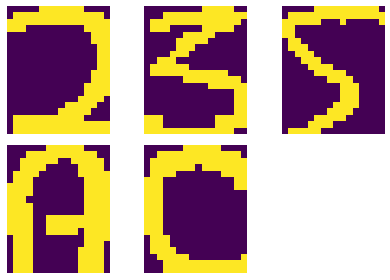

In [6]:
X_rbm = lire_alpha_digit("AC235")
_, p = X_rbm.shape
print("Dimension des données d'entrées :", p)

Beginning training of the RBM...
Epoch 1/500 - RMSE: 0.3740


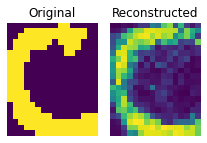

Epoch 101/500 - RMSE: 0.0276


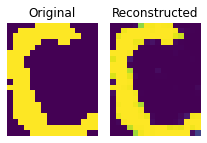

Epoch 201/500 - RMSE: 0.0111


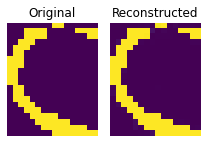

Epoch 301/500 - RMSE: 0.0067


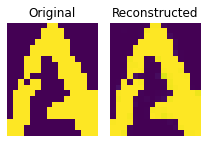

Epoch 401/500 - RMSE: 0.0049


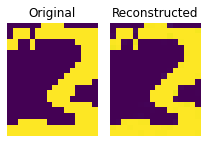

In [7]:
rbm0 = RBM(p, q=512)
err_history0 = rbm0.train(X_rbm, nb_epoch=500, lr=1e-1, epoch_per_plot=100)

Idéalement on devrait tracer l'évolution de la log-vraisemblance pour effectivement constater qu'elle décroît epoch après epoch hélas on n'a pas accès à cette valeur. On trace plutôt l'évolution de l'erreur de reconstruction qui ici nous sert de métrique empirique pour évaluer la ressemblance (vue pixel par pixel) des images reconstruites par rapport aux images originales. Il faut noter que ceci n'est fait qu'à titre indicatif.

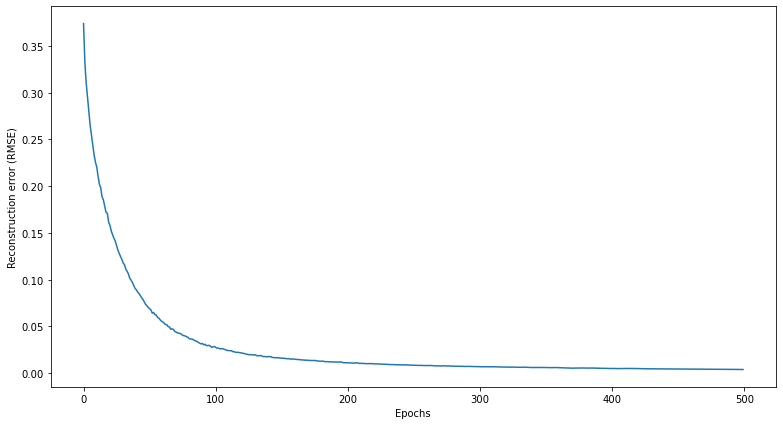

In [8]:
plot_err(err_history0)

On génère de nouvelles images sur la base des celles apprises précédemment par ``rbm0``.

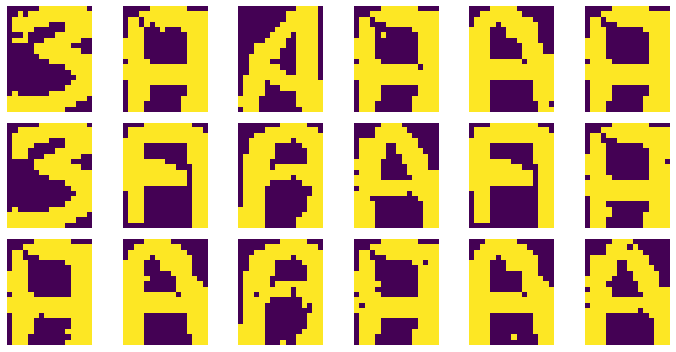

In [12]:
rbm0.generate(nb_iter=100, nrow=3, ncol=6)

Quand on prête attention aux filtres (le filtre étant la matrice des poids d'une unité donnée) du RBM, on aperçoit qu'ils opèrent comme des extracteurs de features (on peut nptamment distinguer les contours, etc.).

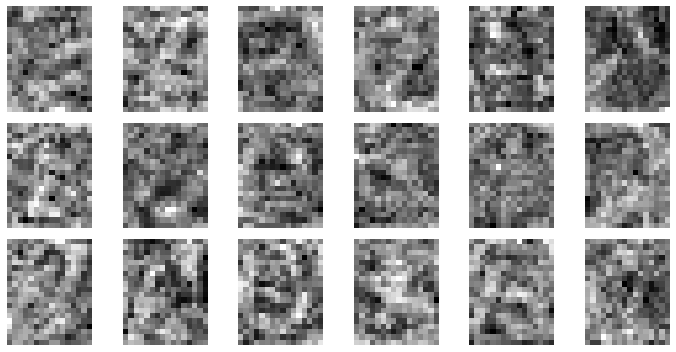

In [10]:
rbm0.show_filter(nrow=3, ncol=6)

## Analyse des hyperparamètres

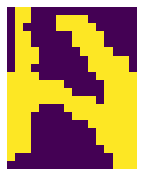

In [703]:
X_rbm_ = lire_alpha_digit('A')

In [704]:
val = 1e-1
lrs = [val*10, val, val/10, val/100, val/1000, val/10000]
err_lr = []
for el in lrs:
    rbm_ = RBM(p, q=256)
    err_history_ = rbm_.train(X_rbm_, nb_epoch=500, lr=el, epoch_per_plot=100, verbose=False)
    err_lr.append(err_history_)

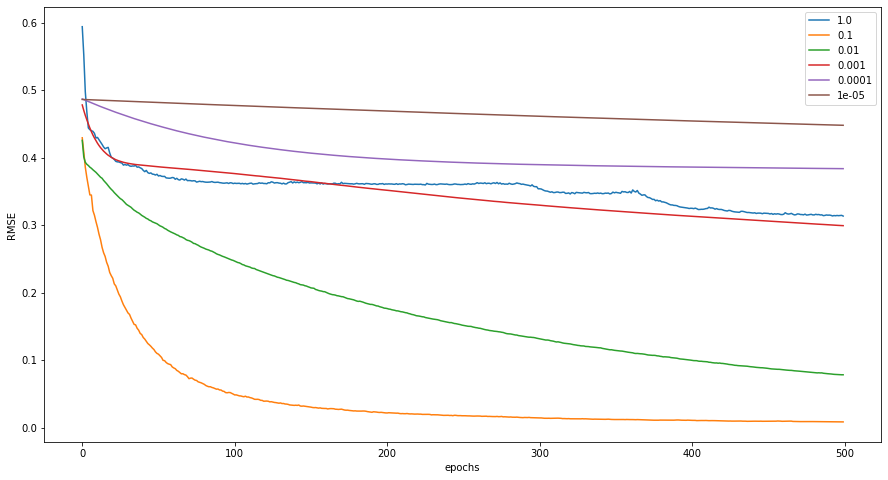

In [529]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_lr):
    plt.plot(el, label=lrs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- On constate que la meilleure valeur de ``lr`` est $0.1$
- Pour la suite, on imposera exclusivement ``lr = 0.1``

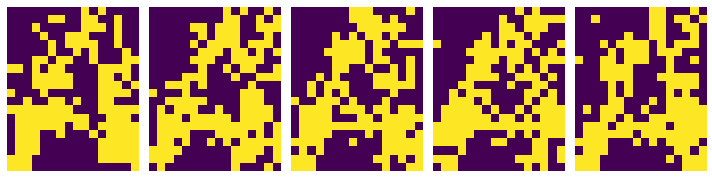

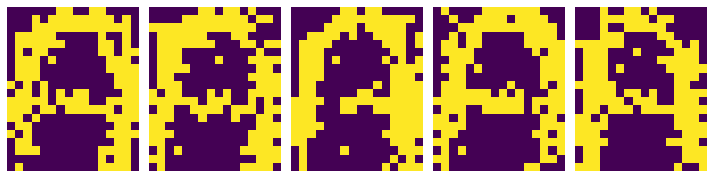

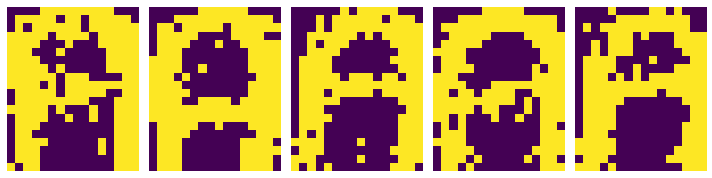

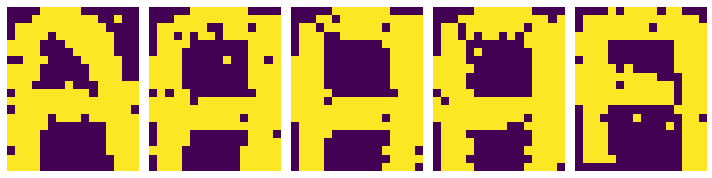

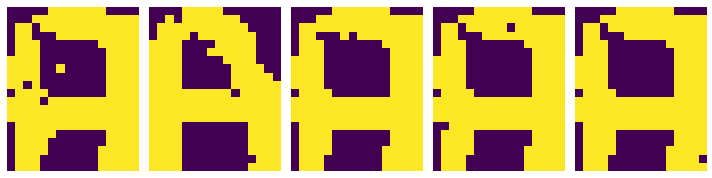

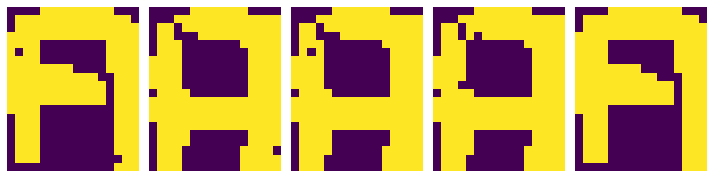

In [530]:
val = 5
epochs = [val, val*2, val*10, val*20, val*100, val*200]
err_ep = []
for el in epochs:
    rbm_ = RBM(p, q=256)
    err_history_ = rbm_.train(X_rbm_, nb_epoch=el, lr=1e-1, epoch_per_plot=100, verbose=False)
    err_ep.append(err_history_)
    rbm_.generate(nb_iter=10, nrow=1)

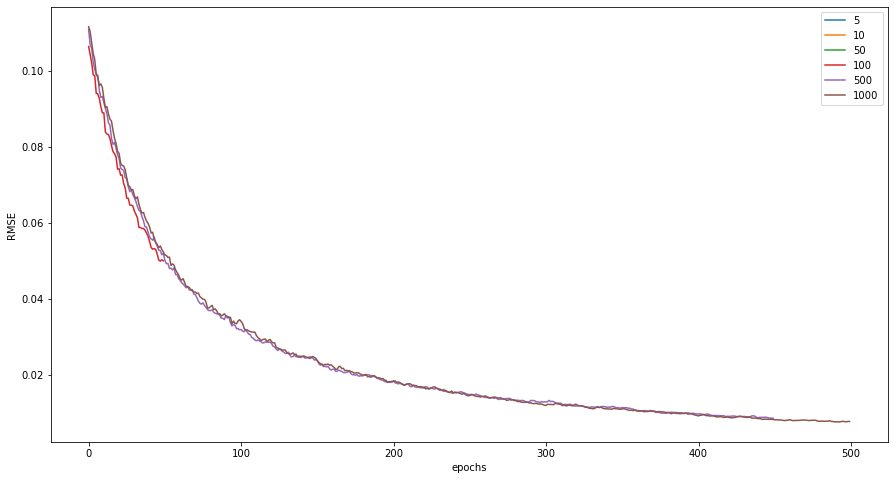

In [531]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_ep):
    plt.plot(el[50:550], label=epochs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- On constate que la meilleure valeur de ``nb_epoch`` est $1000$
- Par ailleurs, on note également que le gain de ``nb_epoch = 1000`` relatif à ``nb_epoch = 500`` est vraiment infime
- Pour la suite, on imposera exclusivement ``nb_epoch = 500`` pour des raisons de convenace

In [532]:
val = 32
qs = [val, val*2, val*4, val*8, val*16, val*32]
err_q = []
for el in qs:
  rbm_ = RBM(p, q=el)
  err_history = rbm_.train(X_rbm_, nb_epoch=500, lr=1e-1, epoch_per_plot=100, verbose=False)
  err_q.append(err_history)

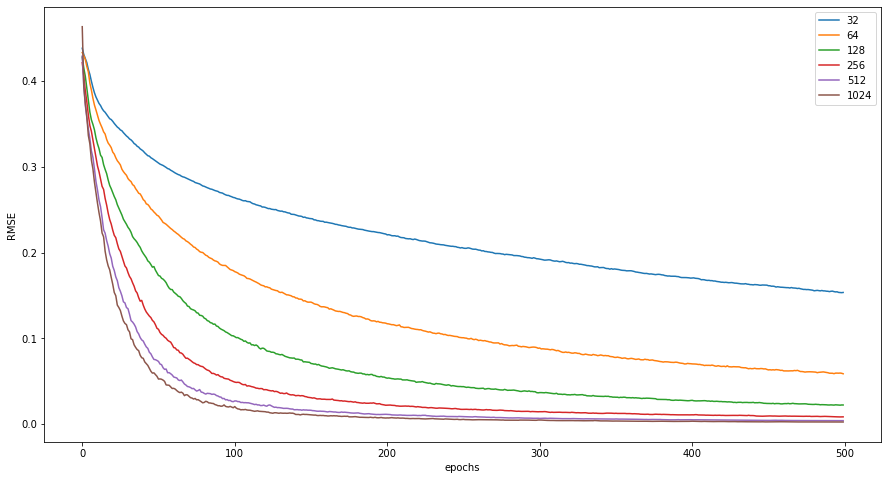

In [533]:
plt.figure(figsize = (15, 8))
for i, el in enumerate(err_q):
    plt.plot(el, label=qs[i])
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

- On constate que la meilleure valeur de ``q`` est $1024$
- Par ailleurs, on note également que le gain de ``q = 1024`` relatif à ``q = 512`` est vraiment infime
- Pour la suite, on imposera exclusivement ``q = 512`` pour des raisons de convenace

# Création de la classe DBN

In [13]:
class DBN():
    def __init__(self, n_units, var=1e-2):
        self.n_layers = len(n_units)-1
        self.layers = [RBM(n_units[i], n_units[i+1], var) for i in range(self.n_layers)]

    def pretrain(self, X, lr=1e-1, batch_size=13, nb_epoch=10, height=20, width=16, epoch_per_plot=1, verbose=True):
        for epoch in range(nb_epoch):
            tmp = X
            for l in range(self.n_layers):
                _ = self.layers[l].train(tmp, lr, batch_size, 1, height, width, verbose=False)
                tmp = self.layers[l].entree_sortie(tmp)
            
            X_rec = self.sortie_entree(tmp)
            if epoch % epoch_per_plot == 0 and verbose:
                print('Epoch {}/{}'.format(epoch+1, nb_epoch))
                rand_idx = np.random.randint(X.shape[0])
                reconstructed_img = X_rec[rand_idx].reshape(height, width)
                
                plt.figure(figsize=(2, 2))
                plt.imshow(reconstructed_img)
                plt.axis('off')
                plt.title('Reconstructed')
                plt.tight_layout()
                plt.show()
        
    def entree_sortie(self, X):
        for l in range(self.n_layers):
            X = self.layers[l].entree_sortie(X)
        
        return X

    def sortie_entree(self, H):
        for l in range(self.n_layers):
            H = self.layers[-l-1].sortie_entree(H)
        
        return H

    def generate(self, nb_iter, thresh=.5, height=20, width=16, ncol=5, nrow=2):
        p = self.layers[0].p
        q = self.layers[-1].q
        nb_images = nrow*ncol

        _, axs = plt.subplots(nrow, ncol, figsize=(10, 5))
        
        for i in range(nb_images):
            v = (np.random.random(p) < thresh).astype(int)
            for _ in range(nb_iter):
                ph_v = self.entree_sortie(v) 
                h = (np.random.random(q) < ph_v).astype(int)
                pv_h = self.sortie_entree(h)
                v = (np.random.random(p) < pv_h).astype(int)
            image = v.reshape(height, width)
            if nrow == 1:
                axs[i].imshow(image)
                axs[i].axis('off')
            elif ncol == 1:
                axs[i].imshow(image)
                axs[i].axis('off')
            else:
                axs[i//ncol, i%ncol].imshow(image)
                axs[i//ncol, i%ncol].axis('off')
        plt.tight_layout()

On crée un DBN ``dbn0`` avec $3$ couches avec respectivement $500$, $200$ et $50$ unités cachées (qui représente l'espace latent de chaque RBM) et on l'entraine sur l'ensemble des images extraites de la base de données ``Binary AlphaDigits`` qui représentent les caractères $2, 5, 9, M, K, E$. L'objectif étant à terme de pouvoir générer des images similaires.

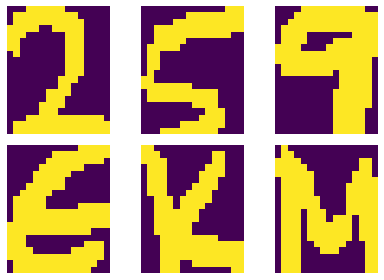

In [14]:
X_dbn = lire_alpha_digit('MKE259')
_, p = X_dbn.shape

Epoch 1/500


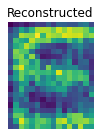

Epoch 101/500


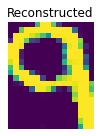

Epoch 201/500


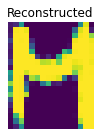

Epoch 301/500


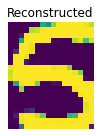

Epoch 401/500


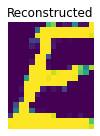

In [15]:
dbn0 = DBN([p, 500, 200, 50])
dbn0.pretrain(X_dbn, nb_epoch=500, epoch_per_plot=100, lr=1e-1)

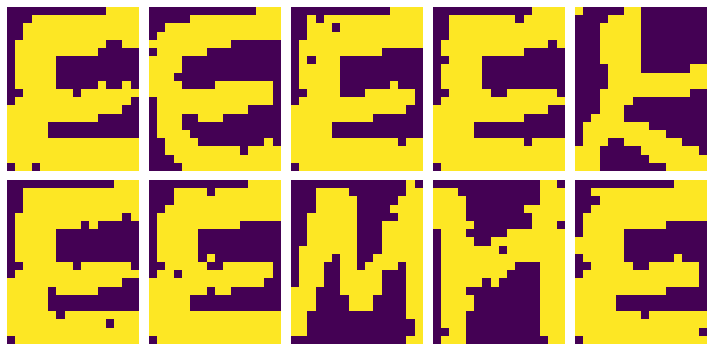

In [23]:
dbn0.generate(nb_iter=10)

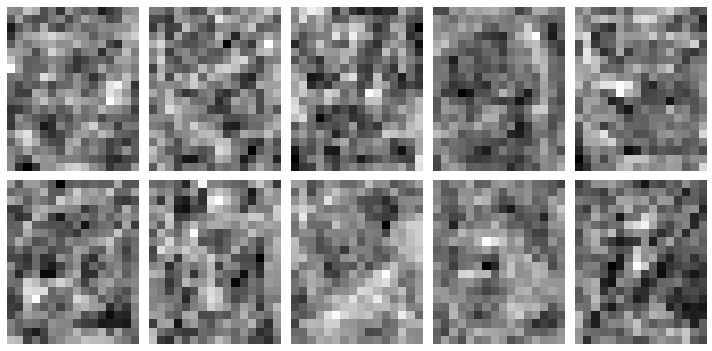

In [24]:
dbn0.layers[0].show_filter()

# MNIST

In [331]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
n_classes = len(np.unique(test_y))
class_names = list(map(str, np.unique(test_y)))
print("Original dimensions train_X: {}".format(train_X.shape))
print("Original dimensions test_X: {}".format(test_X.shape))
print("Original dimensions train_y: {}".format(train_y.shape))
print("Original dimensions test_y: {}".format(test_y.shape))
print("Number of classes: {}\n".format(n_classes))
print(class_names)

N_train = train_X.shape[0]
N_test = test_X.shape[0]
size = train_X.shape[1]*train_X.shape[2]

train_X = train_X.reshape(N_train, size)
test_X = test_X.reshape(N_test, size)
print("Flattened dimensions train_X: {}".format(train_X.shape))
print("Flattened dimensions test_X: {}\n".format(test_X.shape))

thresh = 127
train_X = (train_X>thresh).astype(int)
test_X = (test_X>thresh).astype(int)
X_mnist = np.vstack((train_X, test_X))
y_mnist = np.hstack((train_y, test_y))
print("Full flattened dataset dimensions: {}".format(X_mnist.shape))
print("Full label set dimensions: {}".format(y_mnist.shape))

Original dimensions train_X: (60000, 28, 28)
Original dimensions test_X: (10000, 28, 28)
Original dimensions train_y: (60000,)
Original dimensions test_y: (10000,)
Number of classes: 10

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Flattened dimensions train_X: (60000, 784)
Flattened dimensions test_X: (10000, 784)

Full flattened dataset dimensions: (70000, 784)
Full label set dimensions: (70000,)


In [332]:
def select_digits_mnist(digits):
    mask = (y_mnist == digits[0])
    for label in digits[1:]:
        mask |= (y_mnist == label)
        
    for digit in range(10):
        print('{} samples with label {}'.format(sum(y_mnist[mask] == digit), digit))
    n, _ = X_mnist[mask].shape
    _, axs = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(9):
        ax = axs[i//3, i%3]
        rand_idx = np.random.randint(n)
        rand_sample = X_mnist[mask][rand_idx]
        rand_sample = rand_sample.reshape(28, 28)
        ax.imshow(rand_sample)
        ax.axis('off')
        ax.set_title('label: {}'.format(y_mnist[mask][rand_idx]))
    plt.tight_layout()
    
    return X_mnist[mask], y_mnist[mask]

In [333]:
def select_digits_toclassify(digits):
    mask1 = (train_y == digits[0])
    for label in digits[1:]:
        mask1 |= (train_y == label)
    
    mask2 = (test_y == digits[0])
    for label in digits[1:]:
        mask2 |= (test_y == label)
    
    for digit in range(10):
        print('{} samples with label {}'.format(sum(train_y[mask1] == digit), digit))
    n, _ = train_X[mask1].shape
    _, axs = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(9):
        ax = axs[i//3, i%3]
        rand_idx = np.random.randint(n)
        rand_sample = train_X[mask1][rand_idx]
        rand_sample = rand_sample.reshape(28, 28)
        ax.imshow(rand_sample)
        ax.axis('off')
        ax.set_title('label: {}'.format(train_y[mask1][rand_idx]))
    plt.tight_layout()
    
    return train_X[mask1], pd.get_dummies(train_y)[mask1].values, test_X[mask2], pd.get_dummies(test_y)[mask2].values

# Création de la classe DNN

In [334]:
class DNN():
    def __init__(self, n_classes, dim_layers=None, dbn=None):
        self.n_classes = n_classes
        if dbn is not None:
            self.dbn = dbn
            self.classif_layer = RBM(dbn.layers[-1].q, n_classes)
            self.layers = self.dbn.layers + [self.classif_layer]
            self.n_layers = dbn.n_layers + 1
        elif dim_layers is not None:
            self.dbn = DBN(dim_layers)
            self.classif_layer = RBM(dim_layers[-1], n_classes)
            self.layers = self.dbn.layers + [self.classif_layer]
            self.n_layers = self.dbn.n_layers + 1
        else:
            print("Error: you need to either define dim_layers (list of weights dimensions) or load a pretrained dbn")
            
    def compute_softmax(self, x):
        z = x-x.max(axis=1, keepdims=True)
        z = np.exp(z)
        
        return z/z.sum(axis=1, keepdims=True)
    
    def entree_sortie(self, X):
        outputs = [X]
        for i in range(self.n_layers):
            X = self.layers[i].entree_sortie(X)
            outputs.append(X)
        probs = self.compute_softmax(X)
        
        return outputs, probs
        
    def train(self, X, y, lr=1e-1, batch_size=2048, nb_epoch=100, height=28, width=28, verbose=False):
        n, _ = X.shape
        losses = []
        
        for epoch in range(nb_epoch):
            nllloss = 0
            print(f"\rEpoch {epoch+1}/{nb_epoch}", end="")
            
            for batch in range(0, n, batch_size):
                X_batch = X[batch:batch+batch_size]
                y_batch = y[batch:batch+batch_size]
                current_size = X_batch.shape[0]
                outputs, y_hat = self.entree_sortie(X_batch)
                
                tmp = y_hat - y_batch
                dW = outputs[-2].T @ tmp 
                db = tmp.sum(axis=0)
                self.classif_layer.W -= lr/current_size*dW
                self.classif_layer.b -= lr/current_size*db
                
                nllloss += -np.sum(y_batch * np.log(y_hat))
                for i in range(1, self.n_layers):
                    tmp = (tmp @ self.layers[-i].W.T) * (outputs[-i-1] * (1-outputs[-i-1]))
                    dW = outputs[-i-2].T @ tmp
                    db = tmp.sum(axis=0)
                    self.layers[-i-1].W -= lr/current_size*dW
                    self.layers[-i-1].b -= lr/current_size*db
                    
                        
            losses.append(nllloss/n)
        
        return losses

5923 samples with label 0
6742 samples with label 1
5958 samples with label 2
6131 samples with label 3
5842 samples with label 4
5421 samples with label 5
5918 samples with label 6
6265 samples with label 7
5851 samples with label 8
5949 samples with label 9


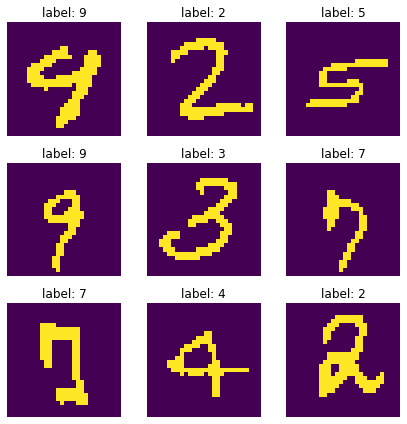

In [335]:
X_train_dnn, y_train_dnn, X_test_dnn, y_test_dnn = select_digits_toclassify(range(10))

In [338]:
_, p = X_train_dnn.shape

dbn1 = DBN([p, 500, 200, 50])
err_history1 = dbn1.pretrain(X_train_dnn[:500], nb_epoch=100, epoch_per_plot=10, batch_size=13, lr=1e-1, height=28, width=28, verbose=False)

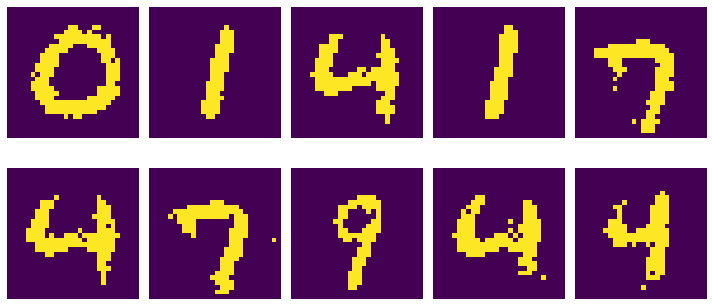

In [339]:
dbn1.generate(nb_iter=100, height=28, width=28, thresh=0.1)

On teste la génération avec le RBM et on constate qu'il est bien limité en ce sens qu'il n'arrive pas à performer autant que le DBN.

In [179]:
rbm1 = RBM(p, q=512)
_ = rbm1.train(X_train_dnn[:500], nb_epoch=500, batch_size=13, lr=1e-1, height=28, width=28, epoch_per_plot=10, verbose=False)

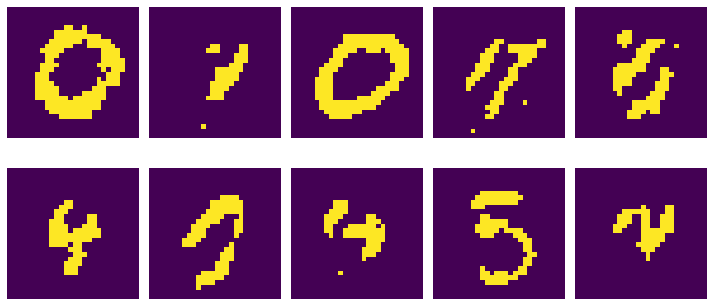

In [283]:
rbm1.generate(nb_iter=100, thresh=.1, height=28, width=28)

On crée un DNN ``dnn1`` avec $4$ couches dont les $3$ premières ont respectivement $500$, $200$ et $50$ unités cachées et la dernière opère la classification multi-classe au moyen d'une activation ``softmax`` et on l'entraine sur l'ensemble des données d'apprentissage extraites de la base de données ``MNIST`` qui représentent les chiffres $0, 1, 2, 3, 4, 5, 6, 7, 8, 9,$. L'objectif étant à terme de pouvoir classifier chaque image avec le bon label.

In [340]:
dnn1 = DNN(n_classes, dim_layers=[p, 500, 200, 50])
logloss1 = dnn1.train(X_train_dnn, y_train_dnn, nb_epoch=50)

Epoch 50/50

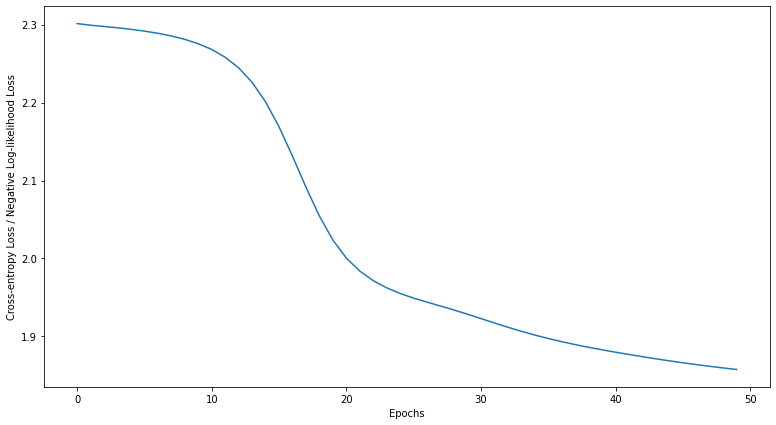

In [341]:
plot_err(logloss1, 'Cross-entropy Loss / Negative Log-likelihood Loss')

In [342]:
_, y_hat1 = dnn1.entree_sortie(X_test_dnn)
np.unique(np.argmax(y_hat1, axis=1))

array([0, 1, 2, 3, 4, 6, 7], dtype=int64)

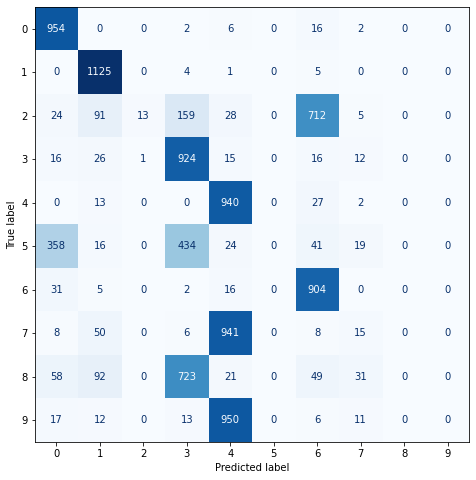

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       980
           1       0.79      0.99      0.88      1135
           2       0.93      0.01      0.02      1032
           3       0.41      0.91      0.56      1010
           4       0.32      0.96      0.48       982
           5       0.00      0.00      0.00       892
           6       0.51      0.94      0.66       958
           7       0.15      0.01      0.03      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.49     10000
   macro avg       0.38      0.48      0.34     10000
weighted avg       0.39      0.49      0.35     10000



C:\Users\davys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\davys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\davys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [343]:
## Display the visualization of the connfusion matrix
cfm1 = confusion_matrix(np.argmax(y_test_dnn, axis=1), np.argmax(y_hat1, axis=1))
_, ax1 = plt.subplots(1, 1, figsize=(8, 8))
cmplot = ConfusionMatrixDisplay(cfm1)
cmplot.plot(cmap='Blues', colorbar=False, ax=ax1)
plt.show()

## Print classification report
report = classification_report(np.argmax(y_test_dnn, axis=1), np.argmax(y_hat1, axis=1))
print(report)

In [344]:
dnn2 = DNN(n_classes, dbn=dbn1)
logloss2 = dnn2.train(X_train_dnn, y_train_dnn, nb_epoch=50)

Epoch 50/50

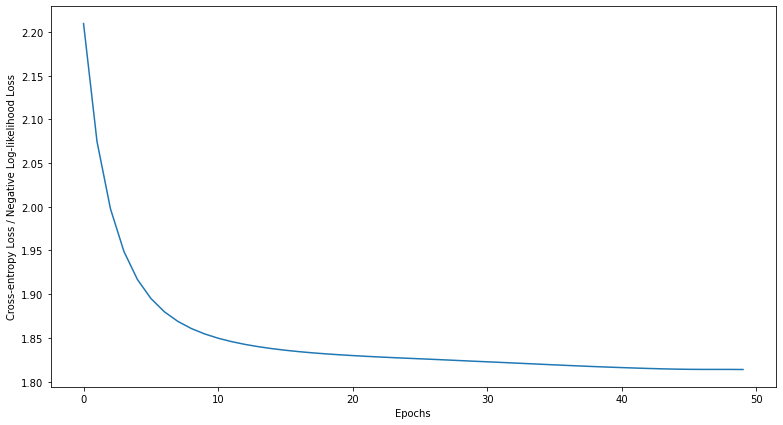

In [345]:
plot_err(logloss2, 'Cross-entropy Loss / Negative Log-likelihood Loss')

In [346]:
_, y_hat2 = dnn2.entree_sortie(X_test_dnn)
np.unique(np.argmax(y_hat2, axis=1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

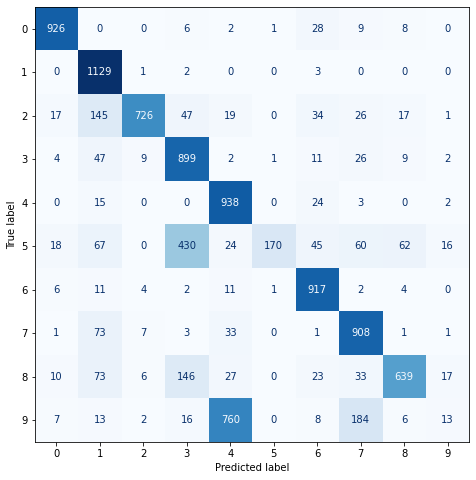

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.72      0.99      0.83      1135
           2       0.96      0.70      0.81      1032
           3       0.58      0.89      0.70      1010
           4       0.52      0.96      0.67       982
           5       0.98      0.19      0.32       892
           6       0.84      0.96      0.89       958
           7       0.73      0.88      0.80      1028
           8       0.86      0.66      0.74       974
           9       0.25      0.01      0.02      1009

    accuracy                           0.73     10000
   macro avg       0.74      0.72      0.67     10000
weighted avg       0.73      0.73      0.68     10000



In [347]:
## Display the visualization of the connfusion matrix
cfm1 = confusion_matrix(np.argmax(y_test_dnn, axis=1), np.argmax(y_hat2, axis=1))
_, ax1 = plt.subplots(1, 1, figsize=(8, 8))
cmplot = ConfusionMatrixDisplay(cfm1)
cmplot.plot(cmap='Blues', colorbar=False, ax=ax1)
plt.show()

## Print classification report
report = classification_report(np.argmax(y_test_dnn, axis=1), np.argmax(y_hat2, axis=1))
print(report)